<a href="https://colab.research.google.com/github/nilanshutwinkle/random-notes/blob/master/Learning_Laggraph_Routing_and_Streaming_Modes_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install langchain langchain_openai langchain-experimental langchain-community openai langchain-core langgraph --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.1/438.1 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 12.5 MB/s eta 0:00:00


In [3]:
import os, sys, re, json, asyncio

from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv
from google.colab import userdata

load_dotenv()

False

In [4]:
llm = ChatOpenAI(model = 'gpt-4o-mini', temperature = 0, api_key = userdata.get('OPENAI_API_KEY'))

In [5]:
def multiply(a:int, b:int):
  """ Multiply two numbers """
  return a * b

In [6]:
llm_with_tools = llm.bind_tools([multiply])

In [7]:
def tool_calling_llm(state: MessagesState):
  """ Node that calls the LLM with tools bound. """
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

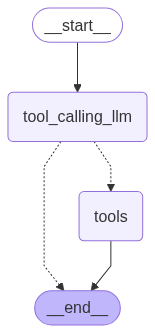

In [10]:
workflow = StateGraph(MessagesState)

workflow.add_node("tool_calling_llm", tool_calling_llm)
workflow.add_node("tools", ToolNode([multiply]))

workflow.add_edge(START, "tool_calling_llm")

# Adding conditional edge based on tool usage
workflow.add_conditional_edges(
    "tool_calling_llm",
    tools_condition # Condition to decide if the model should call the tool
)

workflow.add_edge("tools", END)
graph = workflow.compile()
graph

In [12]:
def simulate():
  user_input = {"messages": [("human", "what is the product of 5 and 3?")]}
  result = graph.invoke(user_input)
  print(result["messages"][-1].pretty_print())

  user_input = {"messages": [("human", "tell me a joke")]}
  result = graph.invoke(user_input)
  print(result["messages"][-1].pretty_print())

simulate()

================================= Tool Message =================================
Name: multiply

15
None
================================== Ai Message ==================================

Why don't scientists trust atoms?

Because they make up everything!
None


## Streaming Modes
---
- Full State Streaming: Streams the entire state after each node
execution ( stream_mode="values" ).
- Updates Streaming: Streams only the updates after each node
execution ( stream_mode="updates" ).
- LLM Token Streaming: Streams the tokens generated by the
language model ( stream_mode="messages" with a model that
supports token streaming).
- You can combine streaming modes using stream_mode=
["messages",”updates”]
By using these streaming modes,

In [ ]:
import operator
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_openai import ChatOpenAI
from typing import Annotated
from typing_extensions import TypedDict
import asyncio
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessageChunk, HumanMessage
# Define the state schema
class State(TypedDict):
    messages: Annotated[list, add_messages]


# Initialize the LLM
model = ChatOpenAI(model="gpt-4o-mini")
# Define a node to handle LLM queries
async def call_llm(state: State):
    messages = state["messages"]
    response = await model.ainvoke(messages)
    return {"messages": [response]}
# Define the graph
workflow = StateGraph(State)
workflow.add_node("call_llm", call_llm)
workflow.add_edge(START, "call_llm")
workflow.add_edge("call_llm", END)
app = workflow.compile()
# Simulate interaction and stream tokens
async def simulate_interaction():
    input_message = {"messages": [("human", "Tell me a very long joke")]}
    first = True
    # Stream LLM tokens
    async for msg, metadata in app.astream(input_message, stream_mode="messages"):
        if msg.content and not isinstance(msg, HumanMessage):
            print(msg.content, end="|", flush=True)
        if isinstance(msg, AIMessageChunk):
            if first:
                gathered = msg
                first = False
            else:
                gathered = gathered + msg
                if msg.tool_call_chunks:
                    (gathered.tool_calls)
asyncio.run(simulate_interaction())

### Combining Streaming Modes => Updates + Custom

In [3]:
from langgraph.graph import StateGraph, MessagesState, START, END
from time import sleep
from langgraph.types import StreamWriter

In [4]:
def long_running_node(state: MessagesState, writer:StreamWriter):
  for i in range(6):
    sleep(1)
    writer({"progress": f"Processing step: {i/5*100}"})
  return {"messages": ["Task completed!!"]}

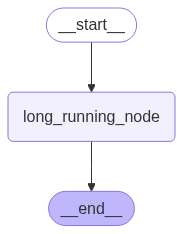

In [5]:
workflow = StateGraph(MessagesState)

workflow.add_node("long_running_node", long_running_node)

workflow.add_edge(START, "long_running_node")
workflow.add_edge("long_running_node", END)
graph = workflow.compile()
graph

In [8]:
def simulate_interaction():
  input_message = {"messages": [("human", "Start a long running task")]}
  for result in graph.stream(input_message, stream_mode=[
                                                        "updates", # streaming mode for delta changes in the nodes
                                                        "custom"   # streaming mode to capture custom node (streaming)
                                                        ]):
    print(result[-1])

In [9]:
simulate_interaction()

{'progress': 'Processing step: 0.0'}
{'progress': 'Processing step: 20.0'}
{'progress': 'Processing step: 40.0'}
{'progress': 'Processing step: 60.0'}
{'progress': 'Processing step: 80.0'}
{'progress': 'Processing step: 100.0'}
{'long_running_node': {'messages': ['Task completed!!']}}


## Disabling Streaming for a particular node

In [18]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_openai import ChatOpenAI
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from google.colab import userdata

In [19]:
llm_streaming = ChatOpenAI(
    model = "gpt-4o-mini",
    temperature = 1,
    streaming = True,
    callbacks = [StreamingStdOutCallbackHandler()],
    api_key = userdata.get("OPENAI_API_KEY")
)

llm_with_no_streaming = ChatOpenAI(
    model = "gpt-4o-mini",
    temperature = 1,
    streaming = False,
    api_key = userdata.get("OPENAI_API_KEY")
)

In [20]:
def create_graph(llm):
  workflow = StateGraph(MessagesState)

  def chatbot(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"] if isinstance(state["messages"], list) else [state["messages"]])]}

  workflow.add_node("chatbot", chatbot)
  workflow.add_edge(START, "chatbot")
  workflow.add_edge("chatbot", END)
  return workflow.compile()

In [22]:
input = {
    "messages": [
        {
            "role": "human",
            "content": "How many 'a' as are there in Atlanta?"
        }
    ]
}

print("With streaming enabled ... ")
graph_with_streaming = create_graph(llm_streaming).invoke(input)

print("\n\nWith streaming disabled ... ")
graph_with_no_streaming = create_graph(llm_with_no_streaming).invoke(input)
for output in graph_with_streaming["messages"]:
  print(output)
  if isinstance(output, dict) and 'chatbot' in output:
    message = output['chatbot']["messages"]
    print(message.content, end = "", flush = True)

With streaming enabled ... 
There are two 'a's in the word "Atlanta."

With streaming disabled ... 
content="How many 'a' as are there in Atlanta?" additional_kwargs={} response_metadata={} id='842cbdd3-9457-4476-beba-aa358b81b0bb'
content='There are two \'a\'s in the word "Atlanta."' additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'} id='run--202ef44e-a58f-462f-bc0a-05bc2539d637-0'
